## The porpose of this notbook is to try to speed up the training prosses as we know that training SVC for this dataset would consume lots of our time. SVC() gave us about 97% if we come close to that accuracy but speed up the training process we have achived our goal with this notebook! Lets try...!

In [3]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette('husl')
sns.set(style = "darkgrid")
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.image import ImageDataGenerator

In [4]:
# Importing data and making train and test dataset

from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [6]:
# making data as panda data frame as it is easier for me to take a look at data
X_train_df= pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)

## EDA

In [7]:
def eda_data(X_df , X_test ,y_train_df, y_test_df):
    print("the shape of X_df {}".format(X_df.shape))
    print("the shape of x_test {}".format(X_test.shape))
    print("the shape of y_df {}".format(y_train_df.shape))
    print("the shape of sample {}".format(y_test_df.shape))
eda_data(X_train_df , X_test_df ,y_train_df, y_test_df)

the shape of X_df (60000, 784)
the shape of x_test (10000, 784)
the shape of y_df (60000, 1)
the shape of sample (10000, 1)


In [8]:
y_train_df.nunique()

0    10
dtype: int64

In [9]:
# Lets take a look att some photos
def image_show(i, data, label):
    x = data[i] # get the vectorized image
    x = x.reshape((28,28)) # reshape it into 28x28 format
    print('The image label of index %d is %d.' %(i, label[i]))
    plt.imshow(x, cmap='gray') # show the image

The image label of index 50 is 3.


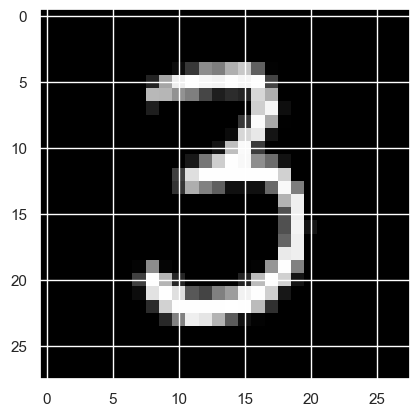

In [10]:
# Showing image from training set 
image_show(50, X_train, y_train)

## preprocessing

In [43]:
# scaling data to make the training process more effective 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# appling PCA as I want to speed up the training process
from sklearn.decomposition import PCA
pca = PCA(.95)
pca.fit(X_train_scaled)

PCA(n_components=0.95)

In [9]:
pca.n_components_

331

In [10]:
pca = PCA(n_components = 331)
X_reduced_train = pca.fit_transform(X_train_scaled)
X_reduced_test = pca.fit_transform(X_test_scaled)

## Data augmentation

In [11]:
# Ading noise to photos becoase we want our model see even photos that dont have complitly black background(incase 
# users uppload images with diffrent background lights)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

In [12]:
# Adding noise dataset to original one

X_total_train = np.concatenate((X_train_mod, X_train), axis=0)
X_total_test = np.concatenate((X_train_mod, X_train), axis=0)
y_total_train = np.concatenate((y_train, y_train), axis=0)
y_total_test = np.concatenate((y_test, y_test), axis=0)

In [13]:
len(y_total_train)

120000

The image label of index 50 is 3.


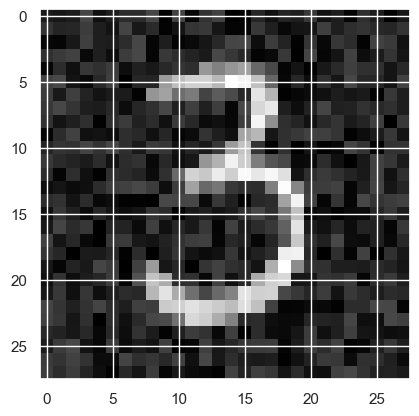

In [14]:
# Showing image from trainning set 
image_show(50, X_train_mod, y_train)

In [15]:
# Shifting images incase when users draw a digits narrow  

from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [14]:
X_train_augmented = [image for image in X_total_train]
y_train_augmented = [label for label in y_total_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_total_train, y_total_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [15]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

## Model centric approches

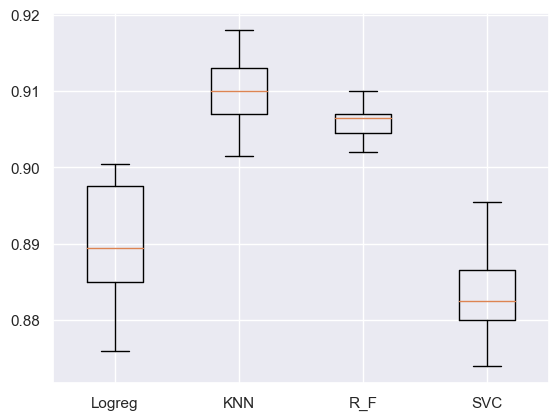

In [14]:
# I know that other coworkers in our team tried SVC() and got reasenable result but they lost lots of time for training the model
# We know that linearSVC() is much faster that SVC(kernel='Linear') so lets try if we get good result with that model but in shorter period of time

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# A fast methot for finding out which model present better with the dataset (Without hyperparameter tuning)
models = {"Logreg": LogisticRegression(), "KNN": KNeighborsClassifier(n_neighbors=10), "R_F" : RandomForestClassifier(), "SVC" : LinearSVC()}
results = []
for model in models.values():
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_augmented[:10000], y_train_augmented[:10000], cv=kf)
    results.append(cv_results)
plt.boxplot(results, labels=models.keys())
plt.show()

In [49]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.svm import LinearSVC
# defining parameter range
param_grid = {'penalty': ['l1', 'l2'], 
              'loss': ['hinge', 'squared_hinge'],
              'C': [0.1, 1, 10, 100, 200, 300, 400]} 
  
grid = RandomizedSearchCV(LinearSVC(), param_distributions=param_grid, n_iter=10, verbose=3, cv=5)
  
# fitting the model for grid search
grid.fit(X_train_scaled[:10000], y_train[:10000])
print("Tuned Hyperparameters :", grid.best_params_)
print("Accuracy :",grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .....C=0.1, loss=hinge, penalty=l2;, score=0.864 total time=  12.8s
[CV 2/5] END .....C=0.1, loss=hinge, penalty=l2;, score=0.897 total time=  13.1s
[CV 3/5] END .....C=0.1, loss=hinge, penalty=l2;, score=0.890 total time=  12.7s
[CV 4/5] END .....C=0.1, loss=hinge, penalty=l2;, score=0.878 total time=  12.9s
[CV 5/5] END .....C=0.1, loss=hinge, penalty=l2;, score=0.878 total time=  12.6s
[CV 1/5] END .......C=200, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .......C=200, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END .......C=200, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END .......C=200, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END .......C=200, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END .........C=1, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .........C=1, loss=hinge, penalty=l

## LinearSVC() was much faster to train as I applied standard scaler and PCA methods but unfortunately the result was not pleasable! But in my test with diffrent models KNN present and intresting result.Very fast and easy algorithm. Let's give it a shot!

## KNN

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
# Define a pipeline to scale the data and fit a KNN model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [ ]:
# Here we use this method to find best values of k and visualise it

from sklearn.neighbors import KNeighborsClassifier
error_rate = []
for i in range(1,10):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_total_train,y_total_train)
    pred_i = knn.predict(X_total_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

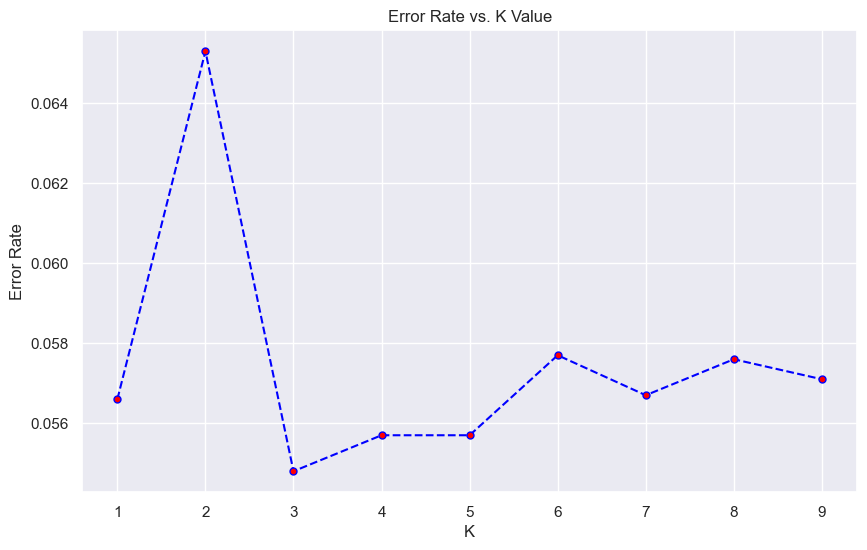

In [47]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [50]:
# defining parameter range
param_grid = { 'n_neighbors' : [3,5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']} 
  
grid = GridSearchCV(KNeighborsClassifier(), param_grid, verbose = 1, cv=5, n_jobs = -1)
  
# fitting the model for grid search
grid.fit(X_total_train[:10000], y_total_train)
print("Tuned Hyperparameters :", grid.best_params_)
print("Accuracy :",grid.best_score_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


In [56]:
from sklearn.metrics import classification_report, confusion_matrix
golden_model = grid.best_estimator_
y_pred = golden_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='distance')
knn.fit(X_total_train, y_total_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_total_train, y_total_train)

KNeighborsClassifier(n_neighbors=3)

In [19]:
# testing how model predict noisi images

from sklearn.metrics import accuracy_score

y_pred = knn.predict(X_test_mod)
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.9684

In [20]:
# testing how model original mnist images

from sklearn.metrics import accuracy_score

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.9705

In [26]:
test = knn.predict([X_test_mod[50]])
print("Predicted digit: ", test[0])

Predicted digit:  6


The image label of index 50 is 6.


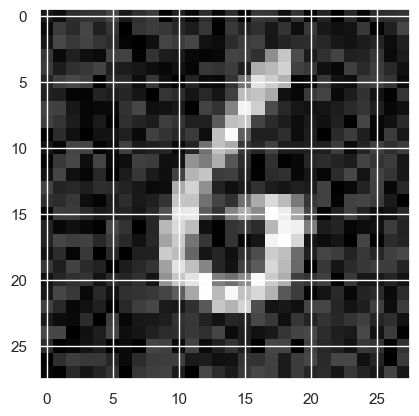

In [24]:
# Showing image from trainning set 
image_show(50, X_test_mod, y_test)

## As we see model KNN was the golden model for this dataset and the training speed is not comparible to LinearSVC() model which is one of fast support vector machines models to train 

In [ ]:
# Saving the model 

import pickle
filename = 'poc_final.sav'
pickle.dump(knn, open(filename, 'wb'))